# Different combination strategies for comparing $k$-step-ahead forecasters

1. AHZ23: Average of running maximum _scaled_ by constant **(NOT an e-process, valid seq test)**
2. CR23: Convert to p -> Combine via harmonic mean -> Convert back to e
3. This work: Use adjusters -> Combine via arithmetic mean

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

import comparecast as cc
import ecombine as ec

In [2]:
PLOTS_DIR = "plots/kstep_forecasts"
os.makedirs(PLOTS_DIR, exist_ok=True)

In [3]:
SCORING_RULE = "brier"

rng = np.random.default_rng(20250107)
cc.set_theme(font_scale=1.75)

## Data: some simulated data, non-stationary mean

In [4]:
NOISE_LEVEL = 0.0
CHANGEPOINT = 0.25
T = 1000
MAX_PROB = 0.8

# Parameters for choosing lambda in the e-process
V_OPT, ALPHA_OPT = 50, 0.1

experiment_name = f"simulated_kstep_forecasts_sigmoid_change{CHANGEPOINT}_noise{NOISE_LEVEL}"

In [5]:
# data params
# period = 1000
pattern = cc.data_utils.synthetic.sigmoid(T, changepoint=CHANGEPOINT)
true_probs = MAX_PROB * pattern + (1 - MAX_PROB) * (1 - pattern)
if NOISE_LEVEL > 0:
    # true_probs = np.clip(true_probs + NOISE_LEVEL * rng.standard_t(df=1, size=T), 0, 1)
    true_probs = np.clip(true_probs + NOISE_LEVEL * rng.standard_normal(size=T), 0, 1)
data = cc.data_utils.synthetic.make_preset(true_probs, rng=rng)
data

,time,y,true_probs
0,1,0,0.204016
1,2,0,0.204096
2,3,1,0.204179
3,4,1,0.204263
4,5,0,0.204348
...,...,...,...
995,996,1,0.800000
996,997,1,0.800000
997,998,1,0.800000
998,999,1,0.800000


## Plotted: 1-step-ahead forecasts

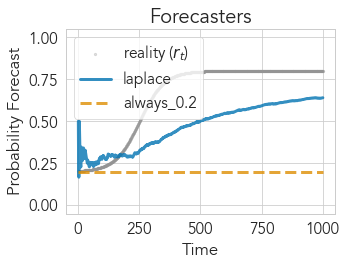

In [6]:
# forecasters = ["k29_rbf0.01", "laplace"]
forecasters = ["laplace", "always_0.2"]
# forecasters = ["always_0.8", "always_0.2"]  # non logt
# remove file if exists
if os.path.exists(f"data/{experiment_name}.csv"):
    os.remove(f"data/{experiment_name}.csv")
data = cc.forecast(data, forecasters, out_file=f"data/{experiment_name}.csv")
cc.plot_forecasts(data, forecasters, plots_dir=f"plots/{experiment_name}", 
                  use_logx=False, legend_out=False, figsize=(5, 4))

Mean Score Difference: 0.1929270883984623


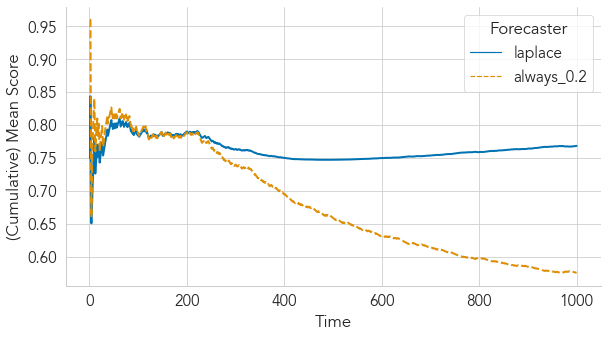

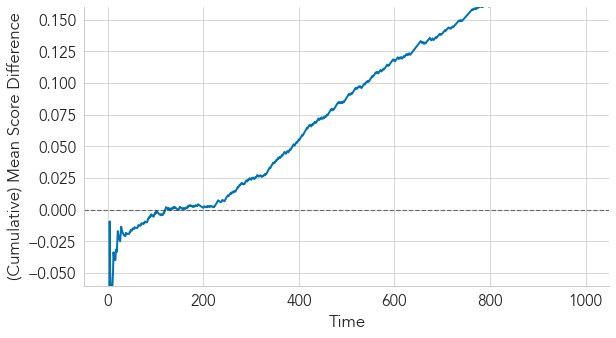

In [7]:
scores, fg1, fg2 = cc.plot_scores_and_diffs(
    data,
    forecasters,
    colors=cc.get_colors()[:len(forecasters)],
    scoring_rule=SCORING_RULE,
    time_var="time",
    xlabel="Time",
    agg_mean=True,
    linewidth=2,
    aspect=1.75,
    # ax1_kwargs=dict(xlim=(9, 2001), xscale="log"),
    # ax2_kwargs=dict(xlim=(9, 2001), ylim=(-0.06, 0.16), xscale="log"),
    ax2_kwargs=dict(ylim=(-0.06, 0.16)),
    save_to=os.path.join(PLOTS_DIR, experiment_name, f"{SCORING_RULE}_scores_and_diffs.pdf"),
)

In [8]:
def compare_e(data, name_p, name_q, lag, aligned_outputs=False, **kwargs):
    """Compare e-processes for the lagged period-wise null at each offset."""

    T = len(data)

    assert lag >= 1
    if lag > 1 and not aligned_outputs:
        # shift predictions by lag
        data = data.copy()
        data[name_p] = data[name_p].shift(lag - 1)
        data[name_q] = data[name_q].shift(lag - 1)
        data = data.dropna()

    ps, qs, ys = [
        data[name].values for name in [name_p, name_q, "y"]
    ]
    times = np.arange(lag, T + 1)
    # print(times, len(ps), len(qs), len(ys))
    results = pd.DataFrame({
        "Time": times,
        name_p: ps,
        name_q: qs,
        "y": ys,
    })
    scoring_rule = cc.get_scoring_rule(SCORING_RULE)
    results["ScoreP"] = scoring_rule(ps, ys)
    results["ScoreQ"] = scoring_rule(qs, ys)
    results["ScoreDiff"] = results["ScoreP"] - results["ScoreQ"]

    # Strategy #0: no adjustment (valid after h extra steps)
    results["Mean*"], aux_outputs = cc.eprocess_expm(
        results["ScoreDiff"].values,
        lag=lag,
        lagged_null="pw",
        v_opt=V_OPT / lag,  # T/lag timesteps per intrinsic time
        alpha_opt=ALPHA_OPT,    # one-sided
        return_aux_outputs=True,
        no_calibration=True,
    )
    # Combination strategy #1 (CR24): adjusted mean
    results["MeanAdjusted"] = cc.combine_lagged_evalues(
        aux_outputs["evalues_per_offset"],
        lagged_null="pw",
        no_calibration=False,
        calibration_strategy="adjuster",
    )
    # Combination strategy #2 (AHZ23): scaled mean of running max (valid at 1/alpha thresholding times)
    mean_max_e = np.maximum.accumulate(aux_outputs["evalues_per_offset"], axis=1).mean(axis=0)
    results["ScaledMeanMax**"] = mean_max_e / (np.exp(1) * np.log(lag))

    # Combination strategy #3 (CR23): calibrated p-harmonic mean
    results["ScaledMeanMaxAdjusted"] = cc.combine_lagged_evalues(
        aux_outputs["evalues_per_offset"],
        lagged_null="pw",
        no_calibration=False,
        calibration_strategy="p-to-e",
    )

    # Offset: 0, 1, 2, 0, 1, 2, ..., 0, 1 (length T)
    results["OffsetIndex"] = np.tile(np.arange(lag), T // lag + 1)[:len(results)]
    for offset in range(lag):
        results[f"Offset={offset}"] = aux_outputs["evalues_per_offset"][offset]
        results[f"Sum{offset}"] = aux_outputs["sums_per_offset"][offset]
        results[f"IntrinsicTime{offset}"] = aux_outputs["intrinsic_times_per_offset"][offset]
    return results

## Exploratory plots

In [9]:
lag = 3
results = compare_e(data, forecasters[0], forecasters[1], lag=lag, aligned_outputs=False)

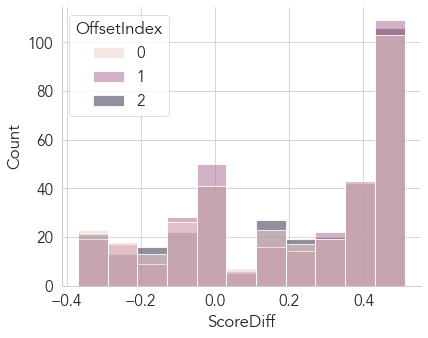

In [10]:
# distribution of score differences
fg = sns.displot(
    data=results,
    x="ScoreDiff",
    hue="OffsetIndex",
    height=5,
    aspect=1.25,
    facet_kws=dict(legend_out=False),
)

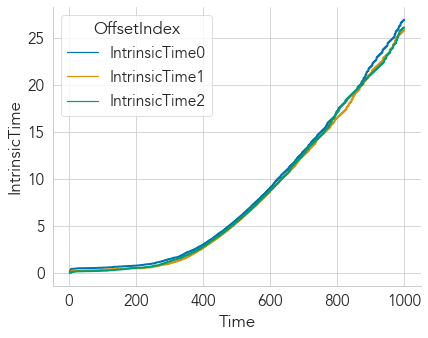

In [11]:
# plot of intrinsic times
feature = "IntrinsicTime"
fg = sns.relplot(
    data=results[["Time"] + [f"{feature}{i}" for i in range(lag)]].melt(
        id_vars=["Time"], var_name="OffsetIndex", value_name=feature),
    x="Time",
    y=feature,
    hue="OffsetIndex",
    kind="line",
    linewidth=2,
    height=5,
    aspect=1.25,
    facet_kws=dict(legend_out=False),
)

## Compare the strategies

In [12]:
# strategies = ["Mean*", "MeanAdjusted", "ScaledMeanRMax**", "ScaledMeanRMaxAdjusted"]
strategies = ["MeanAdjusted", "Mean*", "ScaledMeanMaxAdjusted", "ScaledMeanMax**"]
# fg = ec.plot_eprocess(
#     [results[strategy].values for strategy in strategies],
#     e_label=strategies,
#     time_index=results["Time"], 
#     threshold=(1 / ALPHA_OPT),
#     aspect=1.25, 
# )

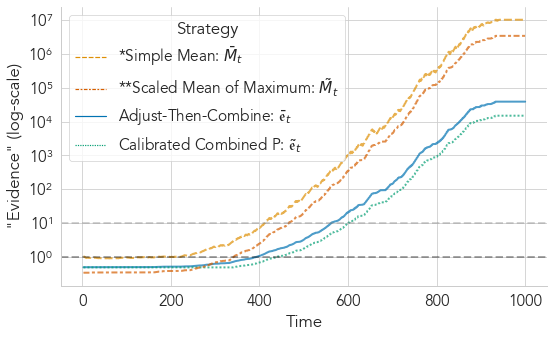

In [13]:
e_df = results[["Time"] + strategies].melt(
    id_vars="Time", var_name="Strategy", value_name="E",
)
fg = sns.relplot(
    data=e_df,
    x="Time",
    y="E",
    hue="Strategy",
    hue_order=strategies,  # keep colors
    style="Strategy",
    style_order=strategies,
    kind="line",
    linewidth=ec.PLOT_DEFAULT_KWARGS["linewidth"],
    alpha=ec.PLOT_DEFAULT_KWARGS["alpha"],
    height=5,
    aspect=1.6,
    facet_kws=dict(legend_out=False),
)
fg.ax.set(
    yscale="log",
    ylabel="\"Evidence\" (log-scale)",
    )

fg.ax.axhline(
    y=1, color="black", alpha=ec.PLOT_DEFAULT_KWARGS["alpha"] * 0.5,
    linestyle="dashed", linewidth=ec.PLOT_DEFAULT_KWARGS["linewidth"],
)
fg.ax.axhline(
    y=10, color="gray", alpha=ec.PLOT_DEFAULT_KWARGS["alpha"] * 0.5,
    linestyle="dashed", linewidth=ec.PLOT_DEFAULT_KWARGS["linewidth"],
)

# reorder legend
strategy_order = [
    "Mean*",
    "ScaledMeanMax**",
    "MeanAdjusted",
    "ScaledMeanMaxAdjusted",
]
# in original order
math_labels = [
    "Adjust-Then-Combine: " + r"$\bar{\mathfrak{e}}_t$",
    "*Simple Mean: " + r"$\bar{M}_t$",
    "Calibrated Combined P: " + r"$\tilde{\mathfrak{e}}_t$",
    "**Scaled Mean of Maximum: " + r"$\tilde{M}_t$",
]
order = [strategies.index(s) for s in strategy_order]
handles, labels = fg.ax.get_legend_handles_labels()
fg.ax.legend(handles=[handles[i] for i in order], labels=[math_labels[i] for i in order], 
             title="Strategy", loc="upper left")

fg.tight_layout()
fg.savefig(os.path.join(PLOTS_DIR, experiment_name, f"EvidenceCompLag{lag}.pdf"), dpi=350, bbox_inches="tight")
None